In [1]:
import time
import pandas as pd

In [2]:
start = time.time()
df = pd.read_csv("../../../en.csv")
time.time() - start

34.45745491981506

In [3]:
df.shape

(7967838, 2)

In [4]:
df.head()

,text,stars
0,"As someone who has worked with many museums, I...",2.0
1,I am actually horrified this place is still in...,1.0
2,I love Deagan's. I do. I really do. The atmosp...,5.0
3,"Oh happy day, finally have a Canes near my cas...",4.0
4,This is definitely my favorite fast food sub s...,5.0


In [5]:
df.isna().sum()

text     0
stars    0
dtype: int64

In [6]:
!pip install spacy
!python -m spacy download en_core_web_sm

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load("en_core_web_sm")

In [8]:
def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text, disable=["ner", "parser", "textcat"])
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON') and (token.pos_ != 'SPACE') and (token.pos_ != 'NUM'):
            lemmas.append(token.lemma_)
    return lemmas

In [9]:
df['text'] = df['text'].str.lower()

In [12]:
good = df[df['stars'].isin([4,5])].sample(700_000, random_state=42)['text']
neutral = df[df['stars'] == 3].sample(700_000, random_state=42)['text']
bad = df[df['stars'].isin([1,2])].sample(700_000, random_state=42)['text']

In [13]:
print(f'len good: {len(good):,}')
print(f'len neutral: {len(neutral):,}')
print(f'len bad: {len(bad):,}')

len good: 700,000
len neutral: 700,000
len bad: 700,000


In [14]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
good_tokens = good.parallel_apply(get_lemmas)
neutral_tokens = neutral.parallel_apply(get_lemmas)
bad_tokens = bad.parallel_apply(get_lemmas)

In [16]:
good_tokens

1202445    [good, vietnamese, restaurant, find, calgary, ...
4553955    [reservation, dinner, labor, day, weekend, wai...
1781331    [amazing, place, chocolate, malt, good, kid, w...
2560289    [go, desert, matt, server, huge, help, choosin...
1675185    [1st, time, great, selection, import, tea, rea...
                                 ...                        
2867704    [have, difficult, financial, situation, past, ...
4202797    [close, office, frequent, week, big, fan, nood...
6223705    [absolutely, adorable, place, variety, homemad...
3258890    [good, spot, date, night, client, entertaining...
2776543    [extremely, happy, speed, service, smog, auto,...
Name: text, Length: 700000, dtype: object

In [17]:
neutral_tokens

3396074    [santisis, place, sport, fan, look, like, stup...
5090170    [sushi, excellent, cody, bartender, good, grip...
1115718    [place, great, modern, look, w, rothko, ish, p...
4881854    [floor, look, nice, issue, get, finish, bathro...
6845977    [stop, store, arrive, hour, early, appointment...
                                 ...                        
214227     [visit, cracker, barrel, drive, phoenix, retur...
6258515    [grow, charlotte, brewery, scene, pilot, brewi...
1661294    [hot, bowl, great, wife, caesar, salad, price,...
3670316    [understand, lure, joey, think, partial, chain...
342625     [small, clean, location, limited, seating, fin...
Name: text, Length: 700000, dtype: object

In [18]:
bad_tokens

5619671    [sephora, hell, avoid, rage, purple, haired, w...
1527091    [place, fuckin, suck, reserve, double, room, d...
6203374    [disappointed, receive, little, $, +, tax, sim...
1482890    [avoid, place, walk, go, birthday, night, want...
3766496    [indirectly, customer, dealership, buy, vespa,...
                                 ...                        
1563975    [go, friday, night, mistake, people, wait, tab...
7872632    [work, starbuck, damn, exactly, work, guy, lob...
6357872    [second, time, visit, restaurant, time, year, ...
774580     [high, price, burger, pretty, vegas, cheap, se...
514190     [high, ticket, price, seat, recline, tiny, the...
Name: text, Length: 700000, dtype: object

In [19]:
from collections import Counter

def counts(tokens):
    word_counts = Counter()

    for _, token in tqdm(tokens.iteritems(), total=len(tokens)):
        word_counts.update(token)

    return dict(word_counts)

In [20]:
good_counts = counts(good_tokens)
neutral_counts = counts(neutral_tokens)
bad_counts = counts(bad_tokens)

In [137]:
good_counts_df = pd.DataFrame(list(good_counts.items()), columns=['word', 'count']).sort_values(ascending=False, by="count")
neutral_counts_df = pd.DataFrame(list(neutral_counts.items()), columns=['word', 'count']).sort_values(ascending=False, by="count")
bad_counts_df = pd.DataFrame(list(bad_counts.items()), columns=['word', 'count']).sort_values(ascending=False, by="count")

In [138]:
good_counts_df.head()

,word,count
0,good,476984
34,great,386742
67,place,373394
6,food,325496
101,time,264039


In [139]:
neutral_counts_df.head()

,word,count
106,good,639871
68,food,502198
1,place,440121
5,like,396793
292,order,362025


In [140]:
bad_counts_df.head()

,word,count
37,time,406346
290,food,388675
275,order,378748
107,place,366175
38,come,362609


In [141]:
good_counts_df.shape, neutral_counts_df.shape, bad_counts_df.shape

((201727, 2), (207577, 2), (226935, 2))

In [142]:
good_counts_df['count'].describe()

count    201727.000000
mean        144.894560
std        2951.400878
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      476984.000000
Name: count, dtype: float64

In [143]:
neutral_counts_df['count'].describe()

count    207577.000000
mean        187.050955
std        3874.569024
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      639871.000000
Name: count, dtype: float64

In [144]:
bad_counts_df['count'].describe()

count    226935.000000
mean        175.781594
std        3659.919839
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      406346.000000
Name: count, dtype: float64

In [160]:
bad_counts_df = bad_counts_df[bad_counts_df['count'] > 100]
neutral_counts_df = neutral_counts_df[neutral_counts_df['count'] > 100]
good_counts_df = good_counts_df[good_counts_df['count'] > 100]

In [161]:
bad_counts_df.shape, neutral_counts_df.shape, good_counts_df.shape 

((8119, 4), (8019, 4), (7572, 4))

In [162]:
good_counts_df['diff'] = good_counts_df['count'] - (neutral_counts_df['count'] + bad_counts_df['count'])

In [163]:
neutral_counts_df['diff'] = neutral_counts_df['count'] - (good_counts_df['count'] + bad_counts_df['count'])

In [164]:
bad_counts_df['diff'] = bad_counts_df['count'] - (good_counts_df['count'] + neutral_counts_df['count'])

In [165]:
bad_counts_df.sort_values('diff', ascending=False)

,word,count,diff,diff_pct
37,time,406346,405512.0,0.995904
107,place,366175,342457.0,0.878336
275,order,378748,332435.0,0.782088
376,service,342134,312226.0,0.839222
25,go,338809,300806.0,0.798292
...,...,...,...,...
3148,socially,101,NaN,-0.913896
15796,evolve,101,NaN,-0.308219
22238,fairy,101,NaN,0.303226
14378,giveaway,101,NaN,0.004975


In [166]:
good_counts_df.sort_values('diff', ascending=False)

,word,count,diff,diff_pct
6,food,325496,323012.0,0.984853
67,place,373394,296846.0,0.659743
118,like,219635,185530.0,0.731182
17,try,170310,167520.0,0.967764
34,great,386742,154705.0,0.250017
...,...,...,...,...
13559,terrasse,101,NaN,-0.427762
11639,understated,101,NaN,0.128492
18801,acquaintance,101,NaN,-0.158333
19522,dipper,101,NaN,0.086022


In [167]:
good_counts_df = good_counts_df.dropna()
neutral_counts_df = neutral_counts_df.dropna()
bad_counts_df = bad_counts_df.dropna()

In [168]:
bad_counts_df.shape, neutral_counts_df.shape, good_counts_df.shape 

((4590, 4), (4590, 4), (4590, 4))

In [169]:
good_counts_df['diff_pct'] = good_counts_df['diff'] / (good_counts_df['count'] + neutral_counts_df['count'] + bad_counts_df['count'])

In [170]:
good_counts_df.sort_values(by='diff_pct', ascending=False).head(20)

,word,count,diff,diff_pct
6,food,325496,323012.0,0.984853
17,try,170310,167520.0,0.967764
135,definitely,122389,119836.0,0.959133
2160,noodle,21417,20939.0,0.956337
522,crab,13469,13115.0,0.948781
212,cheese,55559,53984.0,0.944866
957,wine,27698,26754.0,0.934083
608,receive,14623,14085.0,0.929028
1693,eye,11536,11097.0,0.926681
393,professional,28129,27058.0,0.926644


In [171]:
bad_counts_df['diff_pct'] = bad_counts_df['diff'] / (good_counts_df['count'] + neutral_counts_df['count'] + bad_counts_df['count'])

In [172]:
bad_counts_df.sort_values(by='diff_pct', ascending=False).head(20)

,word,count,diff,diff_pct
37,time,406346,405512.0,0.995904
1077,car,111671,111315.0,0.993644
399,clean,54473,53948.0,0.980908
149,way,117924,116656.0,0.978723
882,close,58968,58290.0,0.977266
826,appointment,49378,48749.0,0.974844
973,girl,40628,39973.0,0.968268
497,home,66990,65676.0,0.961525
184,good,285204,278936.0,0.956991
381,location,91001,88969.0,0.956317


In [173]:
neutral_counts_df['diff_pct'] = neutral_counts_df['diff'] / (good_counts_df['count'] + neutral_counts_df['count'] + bad_counts_df['count'])

In [174]:
neutral_counts_df.sort_values(by='diff_pct', ascending=False).head(20)

,word,count,diff,diff_pct
208,try,220848,219071.0,0.984036
103,service,286778,281942.0,0.966833
310,soft,19199,18837.0,0.962988
331,star,124957,122403.0,0.959941
4,look,154117,150863.0,0.958645
2059,casino,21875,21409.0,0.958283
447,sure,83131,81319.0,0.957336
1868,lobster,17531,17094.0,0.951358
19,small,107171,104473.0,0.950887
1193,give,79805,77655.0,0.947532


In [175]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 37.7MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [180]:
import os
import numpy as np
from PIL import Image
from os import path

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
good_mask = np.array(Image.open(path.join(d, "happy.png")))

In [189]:
good_mask = np.invert(good_mask)

In [190]:
good_frequency = good_counts_df[['word', 'diff_pct']].to_dict()
good_frequency_dict = dict(zip(list(good_frequency['word'].values()), list(good_frequency['diff_pct'].values())))
bad_frequency = bad_counts_df[['word', 'diff_pct']].to_dict()
bad_frequency_dict = dict(zip(list(bad_frequency['word'].values()), list(bad_frequency['diff_pct'].values())))

In [191]:
from wordcloud import WordCloud

In [202]:
good = WordCloud(max_font_size=100, background_color="white")
bad = WordCloud(max_font_size=100, background_color="white")

In [203]:
good.generate_from_frequencies(good_frequency_dict)
bad.generate_from_frequencies(bad_frequency_dict)

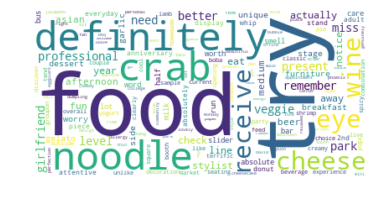

In [204]:
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(good, interpolation="bilinear")
plt.axis("off")
plt.show()

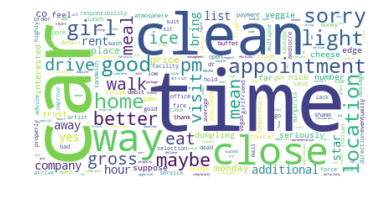

In [205]:
plt.figure()
plt.imshow(bad, interpolation="bilinear")
plt.axis("off")
plt.show()